# Predicting income bracket with Random Forest Classifier

In this project, I will be using a dataset containing census information from UCI’s Machine Learning Repository. By using this census data with a random forest, I will try to predict whether or not a person makes more than $50,000.

The original data set is available at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/census+income). 

Some of the input and output features of interest are:

- age: continuous
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
- sex: Female, Male
- capital-gain: continuous
- capital-loss: continuous
- hours-per-week: continuous
- native country: discrete
- income: discrete, >50K, <=50K

# Investigate the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# Read data into df
col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']
df = pd.read_csv('/kaggle/input/us-census-data/adult-training.csv', header=None, names = col_names)

In [3]:
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# distribution of income values
df.income.value_counts(normalize=True)

income
 <=50K    0.75919
 >50K     0.24081
Name: proportion, dtype: float64

In [5]:
df.describe(include='all')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


## Clean data

In [6]:
# look at categorical features
cat_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']

for i in cat_columns:
    unique_values = df[i].unique()
    print(i)
    print(unique_values)

workclass
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
education
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
marital-status
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
occupation
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
relationship
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
race
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
sex
[' Male' ' Female']
native-country
[' United-States' ' Cuba' ' Jamaica' ' India' '

Looks like all strings in categorical features are preceded by a white space, let's clean that.

In [7]:
for i in cat_columns:
    df[i] = df[i].str.strip()

df.workclass.unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [8]:
#check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# Create train and test datatsets

In [9]:
# Create X with specific features, convert the categorical variables with dummy variables
feature_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race']
X = pd.get_dummies(df[feature_columns], drop_first=True)

# convert >50K to 1 and <=50K to 0
y = (df['income'] == '>50K')*1

y.value_counts()

income
0    24720
1     7841
Name: count, dtype: int64

In [10]:
# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Build and Tune Random Forest Classifiers by Depth

In [11]:
# instantiate Random Forest model without parameters to have baseline
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score fo baseline Random Forest Classifier: ', accuracy)

Accuracy score fo baseline Random Forest Classifier:  0.8200522032857362


In [12]:
# tune the model by exploring the performance over a range of max_depth
max_depth = list(range(1, 26))
accuracy_train = []
accuracy_test = []

for i in max_depth:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred_test = rf.predict(x_test)
    
    accuracy_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_test.append(accuracy_score(y_test, y_pred_test))

print(accuracy_train)
print(accuracy_test)

[0.777142199017199, 0.8005605036855037, 0.8142659705159705, 0.8156480343980343, 0.8183353808353808, 0.8199477886977887, 0.8215601965601965, 0.8228654791154791, 0.824132371007371, 0.8255528255528255, 0.832347972972973, 0.8350353194103194, 0.8389895577395577, 0.8421375921375921, 0.8447097665847666, 0.847627457002457, 0.8497773341523341, 0.8526950245700246, 0.855036855036855, 0.8568412162162162, 0.8579545454545454, 0.8586839680589681, 0.8596437346437347, 0.8602963759213759, 0.8606418918918919]
[0.7891908490710886, 0.8114540150468295, 0.8263473053892215, 0.8283433133732535, 0.8300322432058959, 0.8298787041302012, 0.8306463995086749, 0.8311070167357593, 0.8321817902656226, 0.8311070167357593, 0.8317211730385383, 0.8329494856440964, 0.8335636419468755, 0.8346384154767388, 0.8315676339628435, 0.8315676339628435, 0.8284968524489482, 0.8284968524489482, 0.8248119146322739, 0.8245048364808844, 0.8231229847996315, 0.8246583755565792, 0.8226623675725472, 0.8220482112697681, 0.8215875940426839]


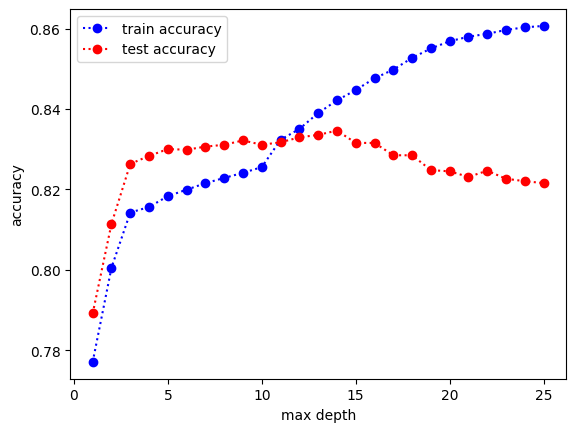

In [13]:
plt.plot(max_depth, accuracy_train, 'bo:')
plt.plot(max_depth, accuracy_test, 'ro:')
plt.legend(['train accuracy', 'test accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

In [14]:
# find largest accuracy and max_depth at which it occurs
best_accuracy = max(accuracy_test)
best_depth = max_depth[np.argmax(accuracy_test)]
print('Best depth: ', best_depth)
print('Best accuracy value: ', best_accuracy)

Best depth:  14
Best accuracy value:  0.8346384154767388


In [15]:
# create  a new model with the best depth and save the feature importance
rf = RandomForestClassifier(max_depth=12)
rf.fit(x_train, y_train)

feature_importance_df = pd.DataFrame(zip(x_train.columns, rf.feature_importances_), columns=['feature', 'importance'])
feature_importance_df.sort_values(by='importance', ascending=False)

,feature,importance
1,capital-gain,0.373671
0,age,0.243841
3,hours-per-week,0.141255
2,capital-loss,0.139395
4,sex_Male,0.080425
6,race_Black,0.009454
8,race_White,0.006747
5,race_Asian-Pac-Islander,0.003945
7,race_Other,0.001266


## Create Additional Features and Re-Tune

In [16]:
# add new features to X, using the education column
df.education.unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [17]:
# make a new column by grouping into 3 categories the 16 variables in education
df['education_bin'] = pd.cut(df['education-num'], 
                             [0, 9, 13, 16], 
                             labels=['High school and less', 'College to Bachelors', 'Masters and more'])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,education_bin
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,College to Bachelors
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,College to Bachelors
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,High school and less
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,High school and less
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,College to Bachelors


In [18]:
# create X again
feature_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race', 'education_bin']
X = pd.get_dummies(df[feature_columns], drop_first=True)

# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# test the random forest for max_depth
max_depth = list(range(1, 26))
accuracy_train = []
accuracy_test = []

for i in max_depth:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred_test = rf.predict(x_test)
    
    accuracy_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_test.append(accuracy_score(y_test, y_pred_test))

In [19]:
# find largest accuracy and max_depth at which it occurs
best_accuracy = max(accuracy_test)
best_depth = max_depth[np.argmax(accuracy_test)]
print('Best depth: ', best_depth)
print('Best accuracy value: ', best_accuracy)

Best depth:  15
Best accuracy value:  0.85014586212191


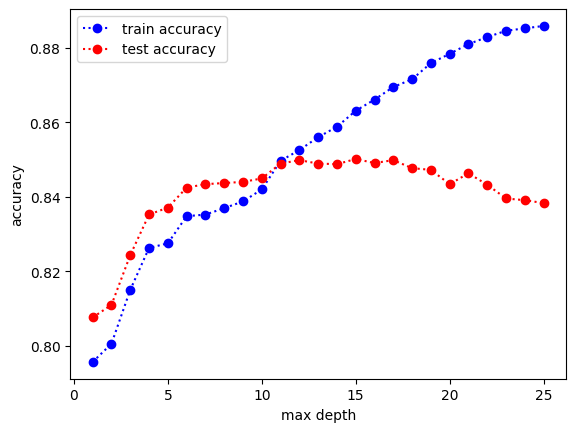

In [20]:
plt.plot(max_depth, accuracy_train, 'bo:')
plt.plot(max_depth, accuracy_test, 'ro:')
plt.legend(['train accuracy', 'test accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

In [21]:
# create  a new model with the best depth and save the feature importance
rf = RandomForestClassifier(max_depth=13)
rf.fit(x_train, y_train)

feature_importance_df = pd.DataFrame(zip(x_train.columns, rf.feature_importances_), columns=['feature', 'importance'])
feature_importance_df.sort_values(by='importance', ascending=False)

,feature,importance
1,capital-gain,0.295915
0,age,0.215281
3,hours-per-week,0.130189
10,education_bin_Masters and more,0.108806
2,capital-loss,0.105028
4,sex_Male,0.077473
9,education_bin_College to Bachelors,0.049390
8,race_White,0.006635
6,race_Black,0.006323
5,race_Asian-Pac-Islander,0.003649


# Conclusions

Accuracy score for Random Forest Classifier:
- baseline model: 0.821
- first tuning (best max_depth=13): 0.835
    - best features: capital-gain, age, hours-per-week, capital-loss
- second tuning (added education_bin, best depth=13): **0.850**
    - best features: same as before, plus a couple of education-bin columns

The best performinf model has a mx_depth=13, and includes the education feature.

Way to expand from here:
- Are there other features that may lead to an even better performace? Consider creating new ones or adding additional features not part of the original feature list.
- Consider tuning hyperparameters based on a different evaluation metric – our classes are fairly imbalanced, AUC of F1 may lead to a different result
- Tune more parameters of the model. You can find a description of all the parameters you can tune in the Random Forest Classifier documentation. For example, see what happens if you tune max_features or n_estimators.